In [ ]:
'''
・外れ値は除去済み
・建築年は経過年数に変更済み

# データ読み込み

In [1]:
import numpy as np
import pandas as pd
raw_data = pd.read_csv('house_data_out.csv')

# 欠損値処理

In [2]:
#dropnaを使って欠損値のレコードを削除
data = raw_data.dropna(how ='any')
print "Housing dataset has {} data points with {} variables each.".format(*data.shape)
type(data)
data.head()

Housing dataset has 825 data points with 5 variables each.


,price,size,district,year,rooms
0,700,40.0,1.0,118,1
1,1820,46.1,1.0,113,2
2,1750,41.0,1.0,94,3
3,1900,55.0,1.0,49,3
4,1950,46.0,1.0,58,3


#

# 1. 単数説明変数モデル

# (1) 特徴データとラベルデータに分割

In [3]:
prices     = data['price']
features = data['size']
features.shape

(825,)

# (2) train_test_splitを使って学習とテスト用データセットを作成

In [4]:
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=123)

//anaconda/envs/py27env/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# (3) データ微調整

In [5]:
print x_train.shape
print y_train.shape
x_train = x_train.reshape((660,1))
y_train = y_train.reshape((660,1))
print x_train.shape
print y_train.shape
print
print x_test.shape
print y_test.shape
x_test  = x_test.reshape((165,1))
y_test  = y_test.reshape((165,1))
print x_test.shape
print y_test.shape

(660,)
(660,)
(660, 1)
(660, 1)

(165,)
(165,)
(165, 1)
(165, 1)


/anaconda/envs/py27env/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
/anaconda/envs/py27env/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda/envs/py27env/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/anaconda/envs/py27env/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


# (4) モデル評価のため決定係数R2スコアの関数を作成

In [6]:
from sklearn.metrics import r2_score
def performance_metric(y_test, predicted):
    score = r2_score(y_test, predicted) 
    return score

# (5) 単回帰モデルの作成及びR2結果

In [7]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(x_train, y_train)
predicted = model.predict(x_test)
performance_metric(y_test, predicted)

0.81057936944842068

#

# 2. 複数説明変数モデル(DT, RF, 重回帰)

# (1) 特徴データとラベルデータに分割

In [8]:
from pandas import Series, DataFrame
prices = data['price']
features = DataFrame(data,columns=['size', 'district', 'year', 'rooms'])
print features.shape
features.head()

(825, 4)


,size,district,year,rooms
0,40.0,1.0,118,1
1,46.1,1.0,113,2
2,41.0,1.0,94,3
3,55.0,1.0,49,3
4,46.0,1.0,58,3


# (2) max_depthおよび学習データ増加に伴うR2スコア

In [42]:
import visuals as vs
'''
https://github.com/udacity/machine-learning/blob/master/projects/boston_housing/visuals.py
'''

'\nhttps://github.com/udacity/machine-learning/blob/master/projects/boston_housing/visuals.py\n'

//anaconda/envs/py27env/lib/python2.7/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


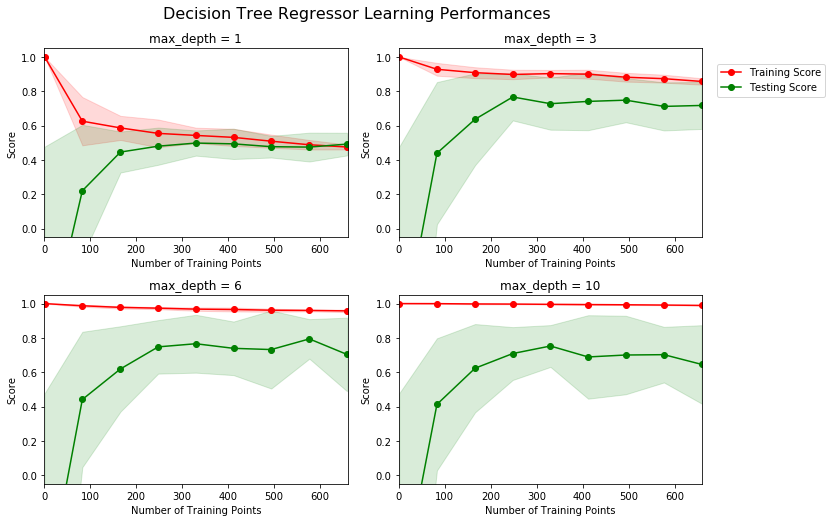

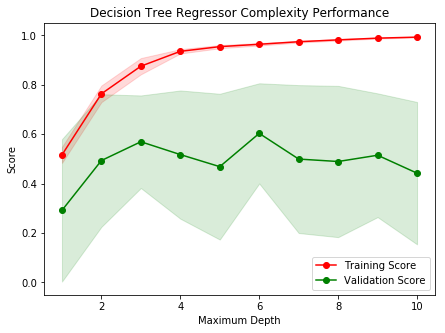

In [41]:
vs.ModelLearning(features, prices)
vs.ModelComplexity(x_train, y_train)

# (3) train_test_splitを使って学習とテスト用データセットを作成

In [17]:
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=123)

# (4) GridSearchCVにて最適なパラメータを確認

# 4-1. DecisionTreeRegressor

In [18]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import ShuffleSplit, GridSearchCV

from sklearn.tree import DecisionTreeRegressor

def fit_model_DT(x, y):
    #　学習とテストデータに分割
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)

    # 予測モデルのオブジェクトを作成
    regressor = DecisionTreeRegressor(random_state=0)
    
    # チューニング・パラメータ
    params = {'max_depth' : [1,2,3,4,5,6,7,8,9,10], 'min_samples_split': [2,4,6]}
    
    # スコアのオブジェクトを作成
    scoring_fnc = make_scorer(performance_metric)

    # grid search のobject作成
    grid = GridSearchCV(regressor, param_grid = params, scoring = scoring_fnc, cv = cv_sets)

    # 特徴データとラベルデータをGridSearchオブジェクトに適用
    grid = grid.fit(x, y)

    return grid.best_estimator_

# GridSearchCV実行用の関数に特徴データとラベルデータを適用
reg_DT = fit_model_DT(features, prices)
# 最適値を返す
print "Parameter 'max_depth' is {} for the optimal model.".format(reg_DT.get_params()['max_depth'])
print "min_samples_split' is {} for the optimal model.".format(reg_DT.get_params()['min_samples_split'])

Parameter 'max_depth' is 6 for the optimal model.
min_samples_split' is 2 for the optimal model.


# R2結果確認(max_depth=6, min_samples_split=2)

In [22]:
model_DT =  DecisionTreeRegressor(max_depth=6, min_samples_split=2)
model_DT.fit(x_train, y_train)
predicted = model_DT.predict(x_test)
performance_metric(y_test, predicted)

0.86025491269817678

# 4-2. RandomForestRegressor

In [80]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import ShuffleSplit, GridSearchCV

from sklearn.ensemble import RandomForestRegressor

def fit_model_RF(x, y):
    #　学習とテストデータに分割
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)

    # 予測モデルのオブジェクトを作成
    regressor = RandomForestRegressor(random_state=0)

    
    # チューニング・パラメータ
    params = {'max_depth' : [1,2,3,4,5,6,7,8,9,10], 'min_samples_split': [2,4,6], 'n_estimators': [5,10,15]}
    
    # スコアのオブジェクトを作成
    scoring_fnc = make_scorer(performance_metric)

    # grid search のobject作成
    grid = GridSearchCV(regressor, param_grid = params, scoring = scoring_fnc, cv = cv_sets)

    # 特徴データとラベルデータをGridSearchオブジェクトに適用
    grid = grid.fit(x, y)

    return grid.best_estimator_

# GridSearchCV実行用の関数に特徴データとラベルデータを適用
reg_RF = fit_model_RF(features, prices)

# 最適値を返す
print "Parameter 'max_depth' is {} for the optimal model.".format(reg_RF.get_params()['max_depth'])
print "min_samples_split' is {} for the optimal model.".format(reg_RF.get_params()['min_samples_split'])
print "n_estimators' is {} for the optimal model.".format(reg_RF.get_params()['n_estimators'])

Parameter 'max_depth' is 8 for the optimal model.
min_samples_split' is 2 for the optimal model.
n_estimators' is 10 for the optimal model.


# R2結果確認(max_depth=8, min_samples_split=2, n_estimators=10)

In [74]:
model_RF =  RandomForestRegressor(max_depth=8, min_samples_split=2, n_estimators=10)
model_RF.fit(x_train, y_train)
predicted = model_RF.predict(x_test)
performance_metric(y_test, predicted)

0.67307733757574018

# 〜 参考 〜

# 4-3. linearRegression　重回帰分析

In [81]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import ShuffleSplit, GridSearchCV

from sklearn import linear_model

def fit_model_LM(x, y):
    #　学習とテストデータに分割
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)

    # 予測モデルのオブジェクトを作成
    regressor =  linear_model.LinearRegression()

    
    # チューニング・パラメータ
    params = {}
    
    # スコアのオブジェクトを作成
    scoring_fnc = make_scorer(performance_metric)

    # grid search のobject作成
    grid = GridSearchCV(regressor, param_grid = params, scoring = scoring_fnc, cv = cv_sets)

    # 特徴データとラベルデータをGridSearchオブジェクトに適用
    grid = grid.fit(x, y)

    return grid.best_estimator_

# GridSearchCV実行用の関数に特徴データとラベルデータを適用
reg_LM = fit_model_LM(features, prices)

# 最適値を返す
reg_LM

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

# R2結果確認

In [82]:
model_LM =  linear_model.LinearRegression()
model_LM.fit(x_train, y_train)
predicted = model_LM.predict(x_test)
performance_metric(y_test, predicted)

0.82361119781370762

# 4-4. KNeighborsRegressor

In [26]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import ShuffleSplit, GridSearchCV

from sklearn.neighbors import KNeighborsRegressor

def fit_model_KN(x, y):
    #　学習とテストデータに分割
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)

    # 予測モデルのオブジェクトを作成
    regressor =  KNeighborsRegressor()

    
    # チューニング・パラメータ
    params = {'n_neighbors':  [2,5,7,10,15]}
    
    # スコアのオブジェクトを作成
    scoring_fnc = make_scorer(performance_metric)

    # grid search のobject作成
    grid = GridSearchCV(regressor, param_grid = params, scoring = scoring_fnc, cv = cv_sets)

    # 特徴データとラベルデータをGridSearchオブジェクトに適用
    grid = grid.fit(x, y)

    return grid.best_estimator_

# GridSearchCV実行用の関数に特徴データとラベルデータを適用
reg_KN = fit_model_KN(features, prices)

# 最適値を返す
print "Parameter 'max_depth' is {} for the optimal model.".format(reg_KN.get_params()['n_neighbors'])

Parameter 'max_depth' is 5 for the optimal model.


# R2結果確認(n_neighbors=5)

In [38]:
model_KN = KNeighborsRegressor(n_neighbors=5)
model_KN.fit(x_train, y_train)
predicted = model_KN.predict(x_test)
performance_metric(y_test, predicted)

0.69406151394243132